# UNET SEGMENTATION

Arxiv Link: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>

<ul>
<li>UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.</li>
 
<li>UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.</li>
</ul>

## 1.1 Architecture

<img src="images/u-net-architecture.png"/>

<h3>UNet Architecture has 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

## 1.3 Dataset
Link: <a href="https://www.kaggle.com/c/data-science-bowl-2018">Data Science Bowl 2018</a>
Find the nuclei in divergent images to advance medical discovery

## 1.4 Code

In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

Using TensorFlow backend.


## Data Generator

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        onlyImagefiles = [f for f in listdir(image_dir) if isfile(join(image_dir, f))]
        onlyLabelfiles = [f for f in listdir(label_dir) if isfile(join(label_dir, f))]
        onlyImagefiles.sort()
        onlyLabelfiles.sort()
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [3]:
image_size = 128
train_path = "dataset/stage1_train/"
epochs = 50
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [19]:
from os import listdir
from os.path import isfile,join
class GetData():
	def __init__(self, data_dir):	
		images_list =[]		
		labels_list = []		
		self.source_list = []
		label_dir = os.path.join(data_dir, "Labels")
		image_dir = os.path.join(data_dir, "Images")
		self.image_size = 128
		examples = 0
		print("loading images")
		onlyImagefiles = [f for f in listdir(image_dir) if isfile(join(image_dir, f))]
		onlyLabelfiles = [f for f in listdir(label_dir) if isfile(join(label_dir, f))]
		onlyImagefiles.sort()
		onlyLabelfiles.sort()

		for i in range (len(onlyImagefiles)):
			image = cv2.imread(os.path.join(image_dir,onlyImagefiles[i]))
			#im = Image.open(os.path.join(label_dir,onlyLabelfiles[i]),cv2.IMREAD_GRAYSCALE)
			#label = np.array(im)
			label = cv2.imread(os.path.join(label_dir,onlyLabelfiles[i]),cv2.IMREAD_GRAYSCALE)
			#image= cv2.resize(image, (self.image_size, self.image_size))
			#label= cv2.resize(label, (self.image_size, self.image_size))
			image = image[96:224,96:224]
			label = label[96:224,96:224]
			#cv2.imwrite("Pre_"+str(i)+".jpg",label)
			#image = image[...,0][...,None]/255
			label = label>40
			image = image/255
			#image = image[...,None]
			label = label[...,None]
			label = label.astype(np.int32)
			#label = label*255
			#cv2.imwrite("Post_"+str(i)+".jpg",label)
			images_list.append(image)
			labels_list.append(label)
			examples = examples +1
							
		print("finished loading images")
		self.examples = examples
		print("Number of examples found: ", examples)
		self.images = np.array(images_list)
		self.labels = np.array(labels_list)
	def next_batch(self, batch_size):
	
		if len(self.source_list) < batch_size:
			new_source = list(range(self.examples))
			random.shuffle(new_source)
			self.source_list.extend(new_source)

		examples_idx = self.source_list[:batch_size]
		del self.source_list[:batch_size]

		return self.images[examples_idx,...], self.labels[examples_idx,...]

In [20]:
# Base Directory Directory 
base_dir= 'Data'

# Training and Test Directories 
train_dir = os.path.join(base_dir,'Train')
test_dir = os.path.join(base_dir,'Test')
real_dir = os.path.join(base_dir,'Real')

BATCH_SIZE = 1
BUFFER_SIZE = 1000
image_size = 128
EPOCHS = 20
def PreProcessImages():
	train_data = GetData(train_dir)
	test_data = GetData(test_dir)
	real_data = GetData(real_dir)

	return train_data,  test_data, real_data

loading images
finished loading images
Number of examples found:  582
loading images
finished loading images
Number of examples found:  20
loading images
finished loading images
Number of examples found:  20


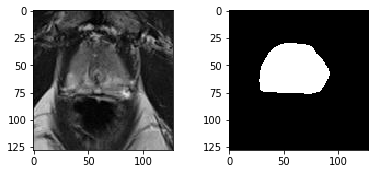

In [21]:
train_data,  test_data, real_data= PreProcessImages()
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(train_data.images[3,:,:,:])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(train_data.labels[3,:,:,:], (image_size, image_size)), cmap="gray")

In [7]:
def ImportImages(train_data,  test_data):
	train_dataset=tf.data.Dataset.from_tensor_slices((train_data.images, train_data.labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
	test_dataset = tf.data.Dataset.from_tensor_slices((test_data.images, test_data.labels)).batch(BATCH_SIZE)
	
	return train_dataset, test_dataset

## Different Convolutional Blocks

In [8]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [9]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [10]:
def f1_metric(y_true, y_pred):
    y_true = y_true >0.4
    y_pred = y_pred>0.4
    y_true = tf.dtypes.cast(y_true,tf.float32)
    y_pred = tf.dtypes.cast(y_pred,tf.float32)

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc",f1_metric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Training the model

In [13]:
train_data,  test_data, real_data= PreProcessImages()
train_dataset, test_dataset= ImportImages(train_data,  test_data)

train_steps = len(train_data.labels)//batch_size
valid_steps = len(test_data.labels)//batch_size

#model.fit_generator(train_data, validation_data=test_data, steps_per_epoch=train_steps, validation_steps=valid_steps, 
 #                   epochs=epochs)
    
model_history = model.fit(train_data.images,train_data.labels, epochs=epochs)

loading images
finished loading images
Number of examples found:  582
loading images
finished loading images
Number of examples found:  20
loading images
finished loading images
Number of examples found:  20
Train on 582 samples
Epoch 1/50
582/582 [==============================] - 47s 81ms/sample - loss: 0.1377 - acc: 0.9418 - f1_metric: 0.8199
Epoch 2/50
582/582 [==============================] - 46s 79ms/sample - loss: 0.1289 - acc: 0.9462 - f1_metric: 0.8320
Epoch 3/50
582/582 [==============================] - 46s 79ms/sample - loss: 0.1185 - acc: 0.9514 - f1_metric: 0.8503
Epoch 4/50
582/582 [==============================] - 44s 76ms/sample - loss: 0.1042 - acc: 0.9566 - f1_metric: 0.8648
Epoch 5/50
582/582 [==============================] - 44s 76ms/sample - loss: 0.0943 - acc: 0.9605 - f1_metric: 0.8719
Epoch 6/50
582/582 [==============================] - 44s 76ms/sample - loss: 0.0888 - acc: 0.9631 - f1_metric: 0.8854
Epoch 7/50
582/582 [==============================] - 44s

## Testing the model

In [14]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
resultCross = model.predict(test_data.images)

resultSame = model.predict(real_data.images)


resultCross = resultCross > 0.4

resultSame = resultSame >0.4

score = model.evaluate(test_data.images,test_data.labels)

print("Cross Domain Loss: "+str(score[0]))

print("Cross Domain Accuracy: "+str(score[1]))

print("Cross Domain F1 score: "+str(score[2]))

score = model.evaluate(real_data.images,real_data.labels)

print("Real Domain Loss: "+str(score[0]))

print("Real Domain Accuracy: "+str(score[1]))

print("Real Domain F1 score: "+str(score[2]))

20/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 27ms/sample - loss: 0.8337 - acc: 0.9440 - f1_metric: 0.8106
Cross Domain Loss: 0.8337125778198242
Cross Domain Accuracy: 0.9440155
Cross Domain F1 score: 0.8105758
20/1 [========================================================================================================================================================================================================================

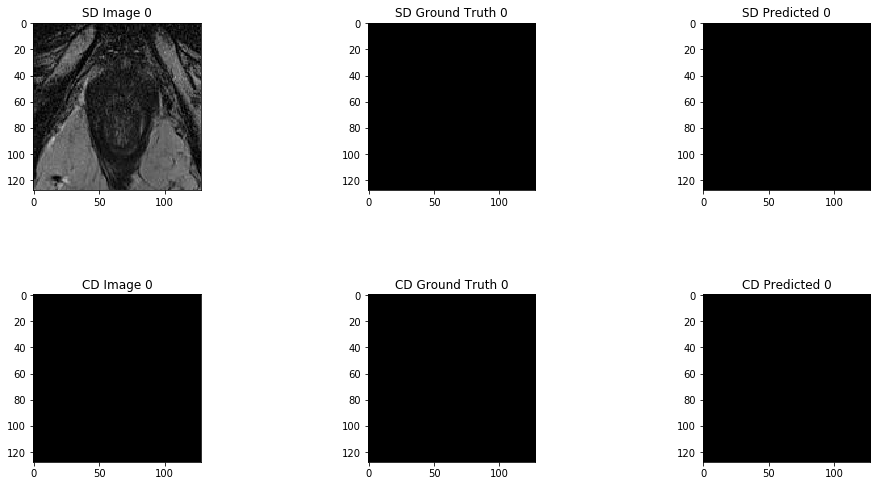

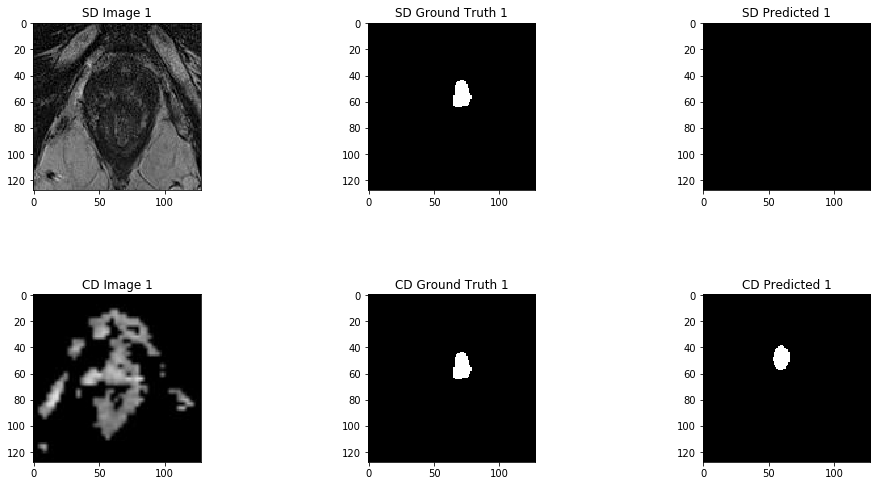

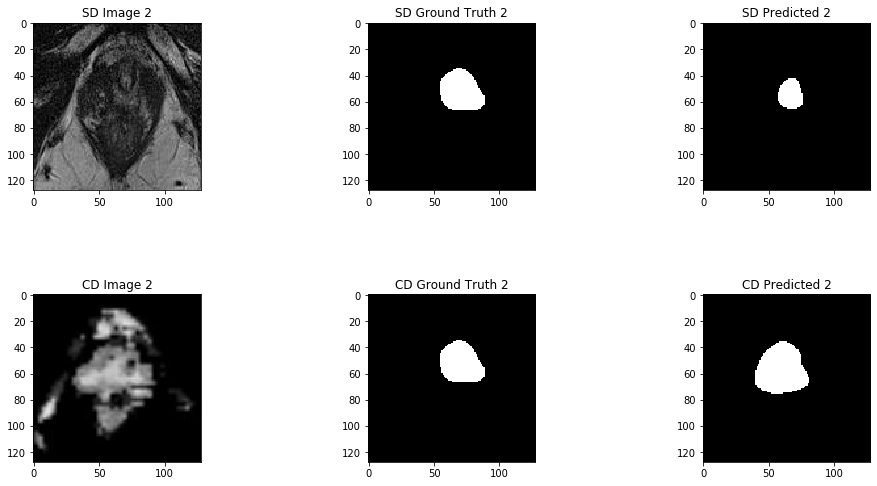

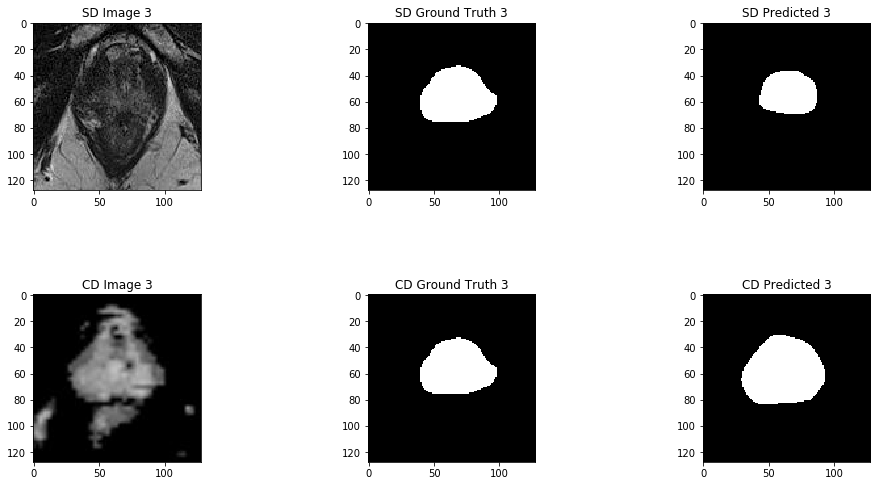

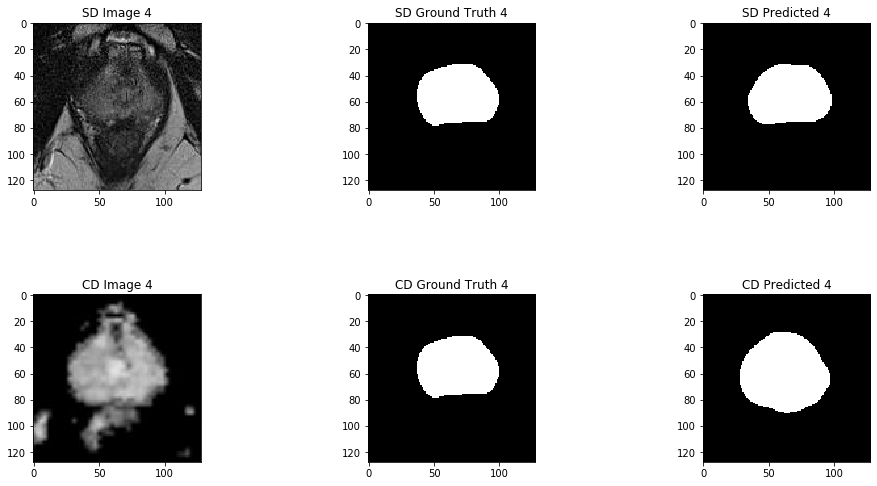

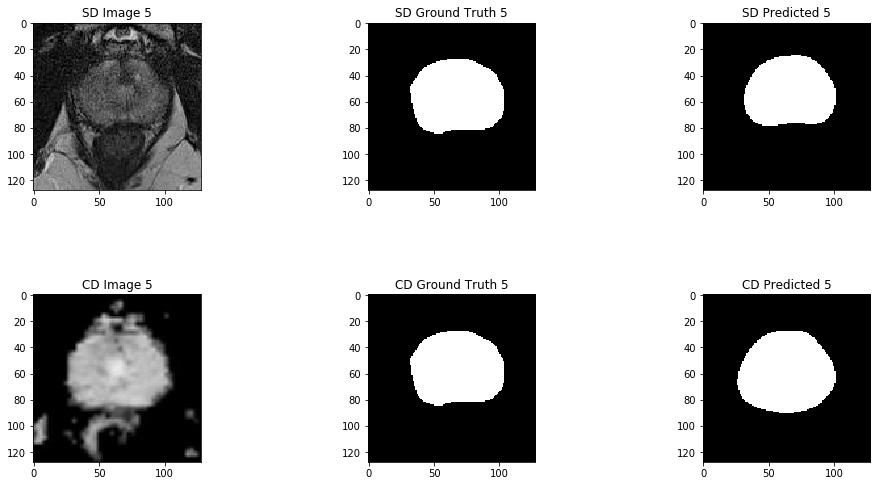

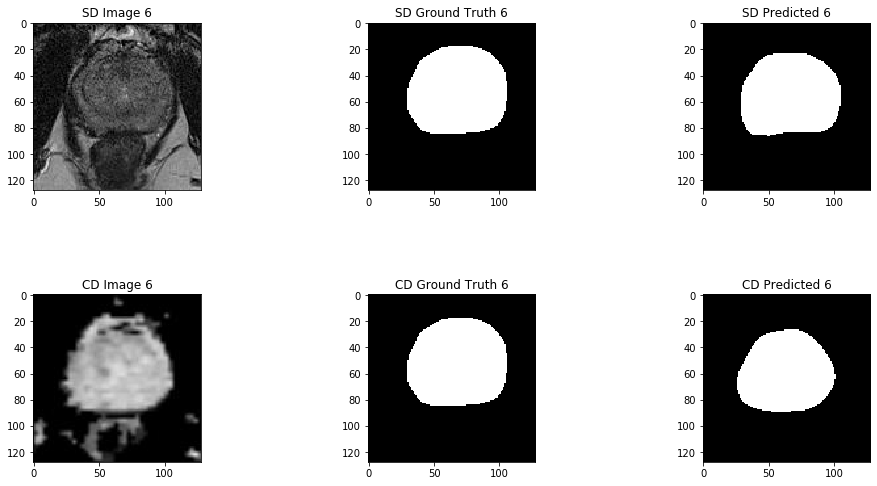

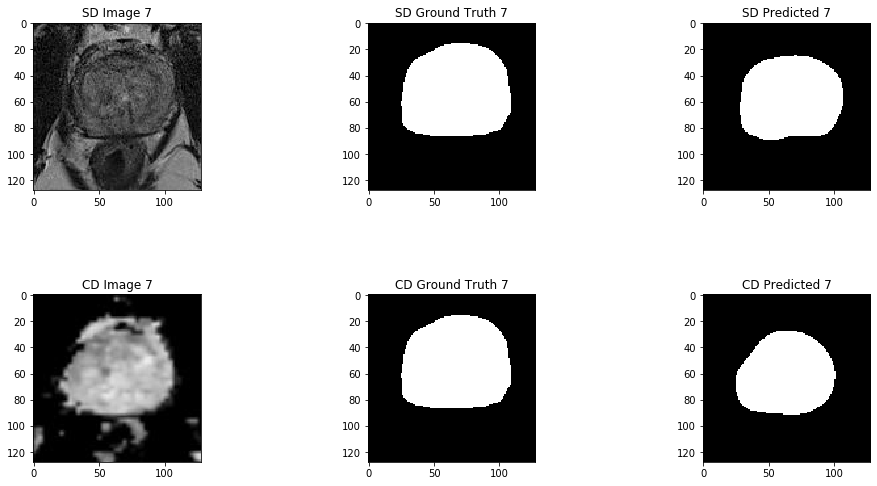

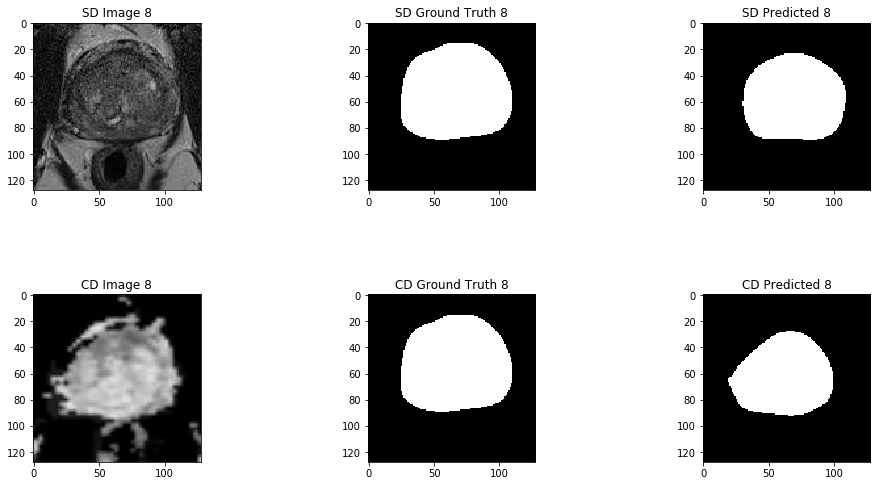

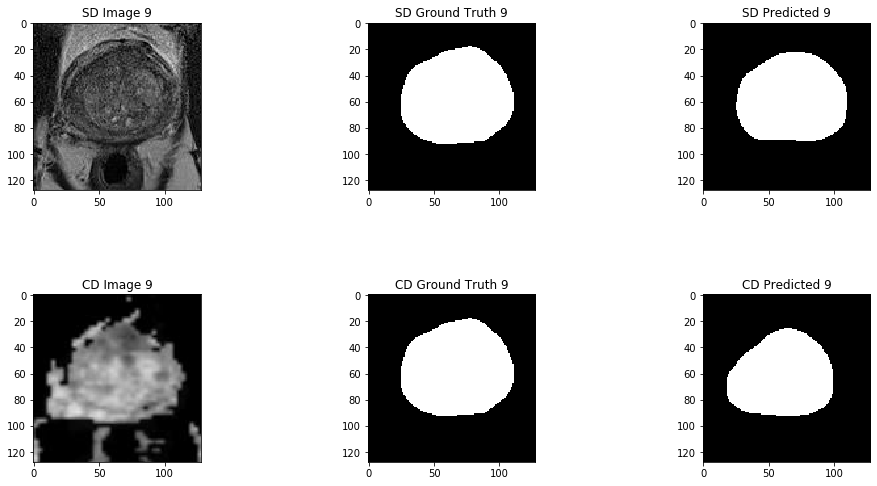

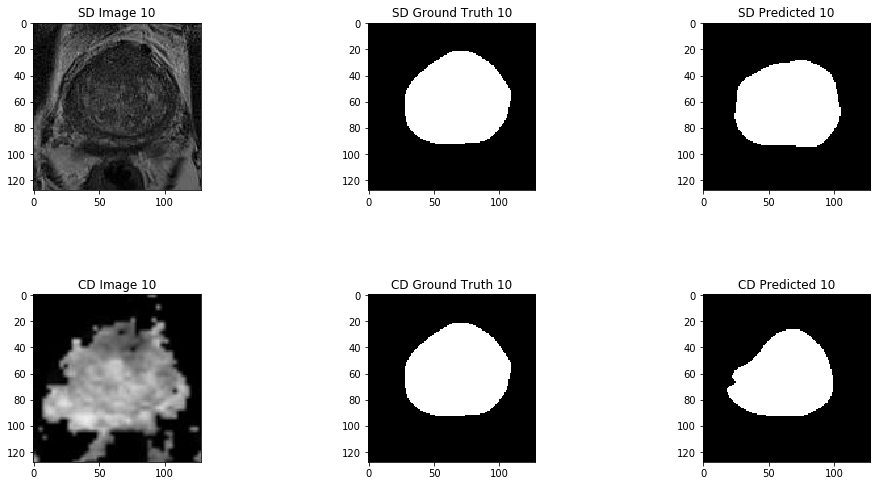

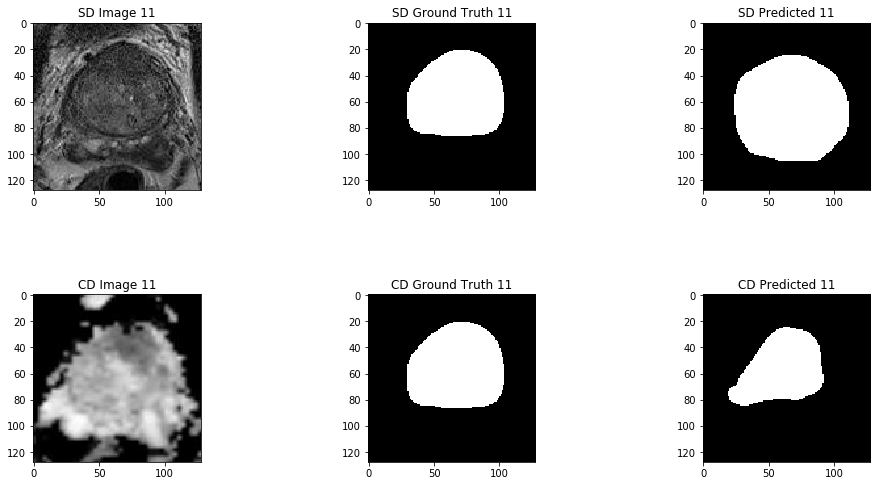

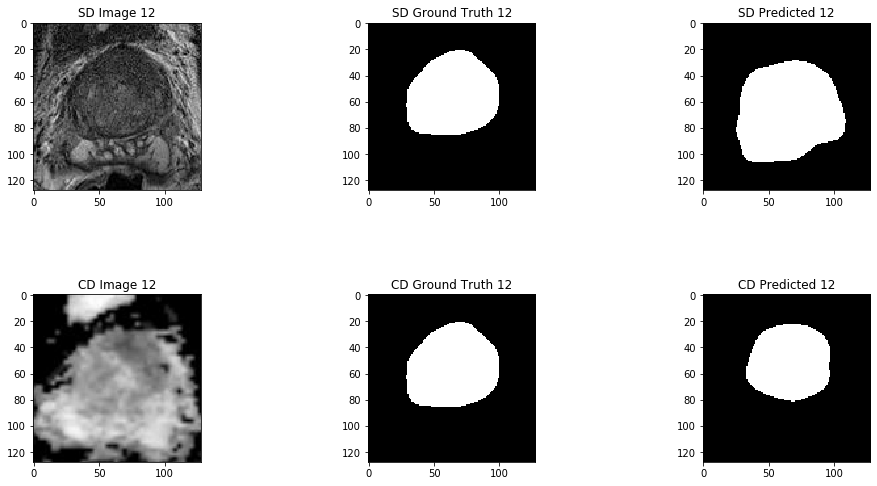

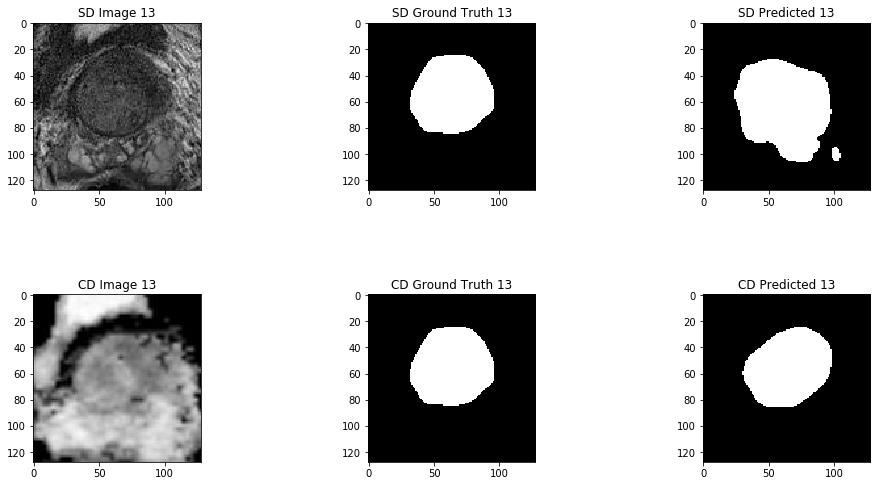

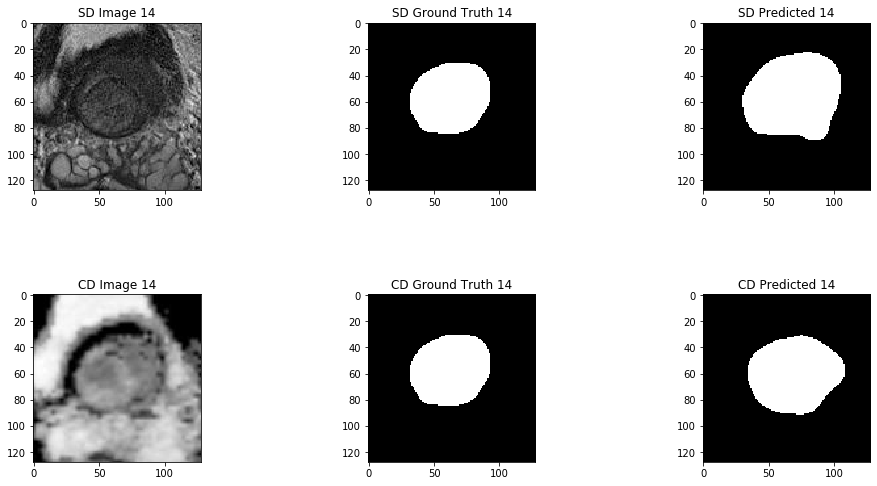

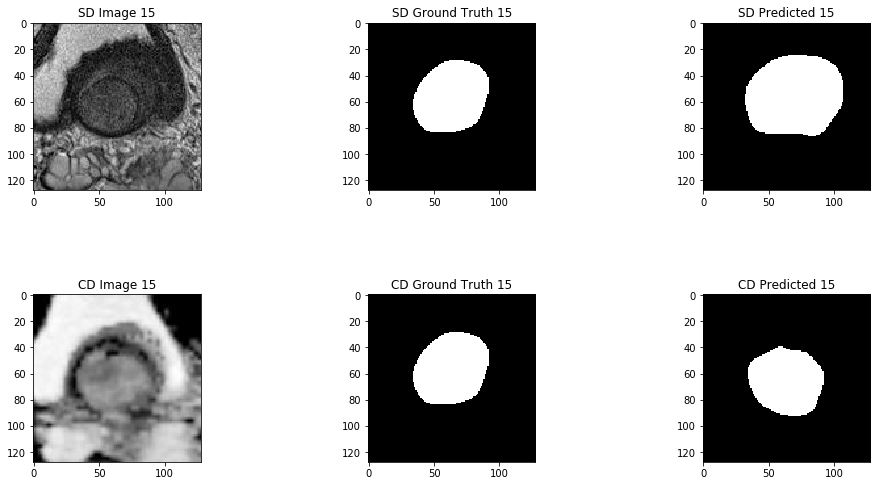

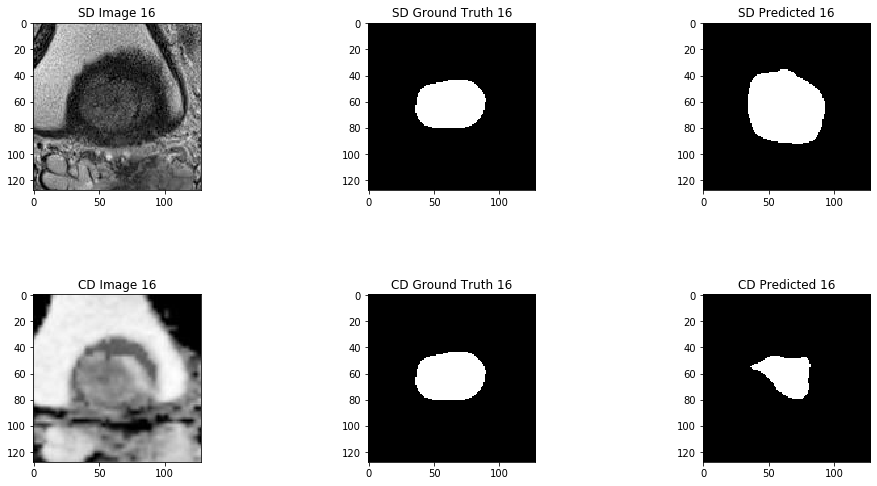

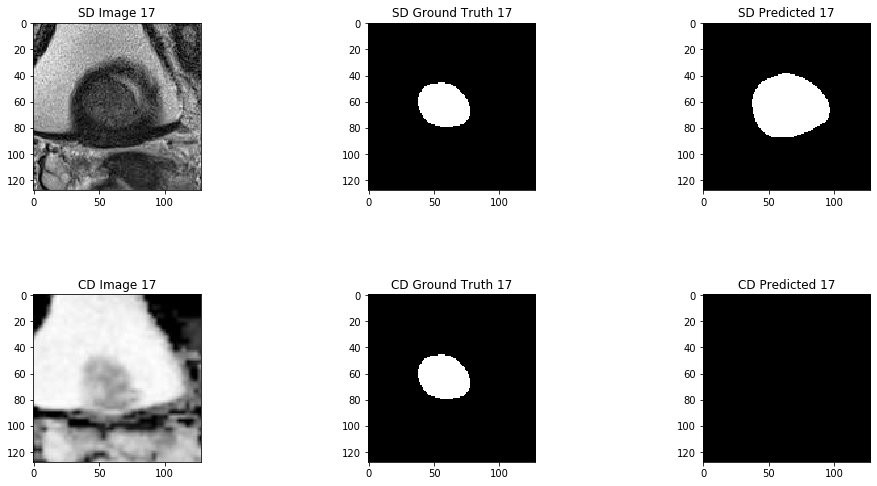

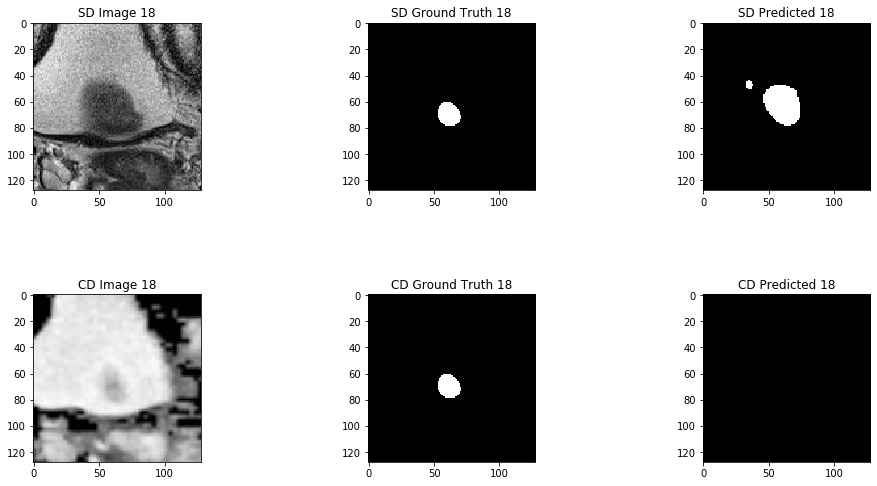

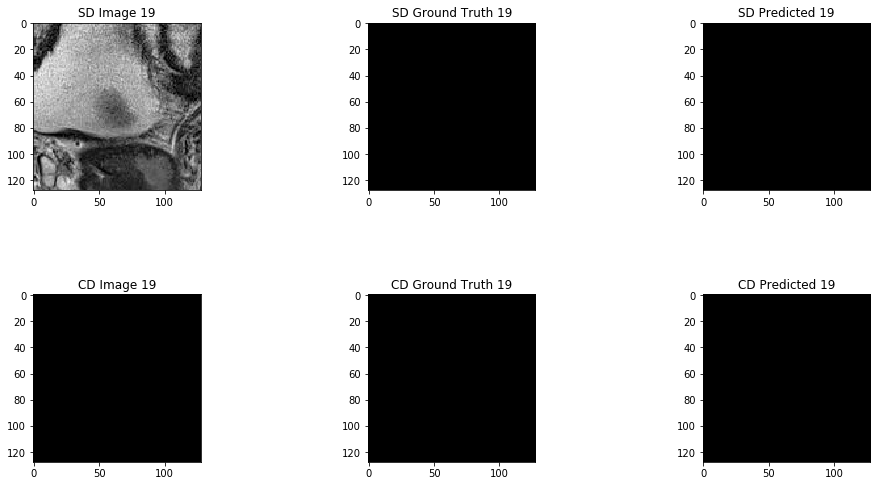

In [15]:
for i in range (20):
    fig = plt.figure(figsize=(15,15))
    #fig.subplots(1,3,figsize=(15,15))
    fig.subplots_adjust(hspace=1, wspace=1)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(test_data.images[i,:,:,:])
    ax.title.set_text("CD Image " + str(i))

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(test_data.labels[i,:,:,:]*255, (image_size, image_size)), cmap="gray")
    ax.title.set_text("CD Ground Truth "+ str(i))

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(resultCross[i]*255, (image_size, image_size)), cmap="gray")
    ax.title.set_text("CD Predicted "+ str(i))

    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(real_data.images[i,:,:,:])
    ax.title.set_text("SD Image "+ str(i))

    ax = fig.add_subplot(2, 3, 2)
    ax.imshow(np.reshape(real_data.labels[i,:,:,:]*255, (image_size, image_size)), cmap="gray")
    ax.title.set_text("SD Ground Truth " + str(i))

    ax = fig.add_subplot(2, 3, 3)
    ax.imshow(np.reshape(resultSame[i]*255, (image_size, image_size)), cmap="gray")
    ax.title.set_text("SD Predicted "+ str(i))
    
    